# Proyecto: Cloud Computing

### Configuración del entorno

In [ ]:
#!pip install mlxtend
#!pip install itemset-mining

In [ ]:
import heapq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocesamiento



#### Importar datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importar base de productos
df = pd.read_csv('/content/drive/MyDrive/Cloud computing/Productos.csv')
df.head()

,Serie,Documento,ProductoId,Descripcion,Cantidad,FechaEmision,ST,Utilidad,Unnamed: 8
0,TB,109176,ARSO,ARROZ SINALOA Escudo de Morelos x kg,249.2,24/01/2022 14:30,0,0.075455,NaN
1,TB,109508,AB2,AZUCAR x kg,5.0,27/01/2022 12:46,0,0.082353,NaN
2,TB,111121,HD,HI DOG ADULTO x kg,25.0,07/02/2022 16:48,0,0.033347,NaN
3,TB,111270,511810,ROYAL CANIN CHIHUAHUA ADULT 4.54 kg,1.0,08/02/2022 17:10,0,0.000726,NaN
4,TB,111459,PC1,PODER CANINO x kg,25.0,10/02/2022 11:56,0,0.032073,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745996 entries, 0 to 745995
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Serie         745996 non-null  object 
 1   Documento     745996 non-null  int64  
 2   ProductoId    745996 non-null  object 
 3   Descripcion   745996 non-null  object 
 4   Cantidad      745996 non-null  float64
 5   FechaEmision  745996 non-null  object 
 6   ST            745996 non-null  int64  
 7   Utilidad      745971 non-null  float64
 8   Unnamed: 8    0 non-null       float64
dtypes: float64(3), int64(2), object(4)
memory usage: 51.2+ MB


In [ ]:
# Crear una llave única usando las columnas 'Serie' y 'Documento'
df['Ticket'] = df['Serie'] + '-' + df['Documento'].astype(str)

In [ ]:
# Eliminar las columnas 'ST' y 'Unnamed: 8'
df = df.drop(['ST', 'Unnamed: 8', 'Serie', 'Documento'], axis=1)

In [ ]:
df.head()

,ProductoId,Descripcion,Cantidad,FechaEmision,Utilidad,Ticket
0,ARSO,ARROZ SINALOA Escudo de Morelos x kg,249.2,24/01/2022 14:30,0.075455,TB-109176
1,AB2,AZUCAR x kg,5.0,27/01/2022 12:46,0.082353,TB-109508
2,HD,HI DOG ADULTO x kg,25.0,07/02/2022 16:48,0.033347,TB-111121
3,511810,ROYAL CANIN CHIHUAHUA ADULT 4.54 kg,1.0,08/02/2022 17:10,0.000726,TB-111270
4,PC1,PODER CANINO x kg,25.0,10/02/2022 11:56,0.032073,TB-111459


In [ ]:
# Limpiar la columna 'Descripcion'
df['Descripcion'] = df['Descripcion'].str.replace(r'\s+', ' ', regex=True)
df['Descripcion'] = df['Descripcion'].str.strip()
df['Descripcion'] = df['Descripcion'].str.replace('*', '', regex=False)
df['Descripcion'] = df['Descripcion'].str.replace('|', '', regex=False)
df['Descripcion'] = df['Descripcion'].str.replace('...', '', regex=False)
df['Descripcion'] = df['Descripcion'].str.replace('#', '', regex=False)

In [ ]:
# Identificar y eliminar filas con valores numéricos en 'FechaEmision'
df['FechaEmision'] = df['FechaEmision'].astype(str)
df = df[~df['FechaEmision'].str.isnumeric()]

In [ ]:
# Convertir la columna 'FechaEmision' a timestamp
df['FechaEmision'] = pd.to_datetime(df['FechaEmision'], format='mixed')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745996 entries, 0 to 745995
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   ProductoId    745996 non-null  object        
 1   Descripcion   745996 non-null  object        
 2   Cantidad      745996 non-null  float64       
 3   FechaEmision  745996 non-null  datetime64[ns]
 4   Utilidad      745971 non-null  float64       
 5   Ticket        745996 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 34.1+ MB


### EDA

In [ ]:
# Limpiar datos negativos
df = df[df['Utilidad'] > 0]

In [ ]:
# Estadistica descriptiva de los campos numéricos
df.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
Cantidad,742951.0,9.544708,24.933064,1.000000e-03,1.000000,3.000000,10.000000,5398.0
Utilidad,742951.0,0.127200,0.084369,1.740000e-07,0.071845,0.118282,0.165455,1.0


In [ ]:
# Eliminar filas con 'Descripcion' vacía
df = df[df['Descripcion'].notna() & (df['Descripcion'] != '')]

In [ ]:
df.shape

(742948, 6)

In [ ]:
# Obtener los valores únicos de las columnas FCNOMBRE y FCIDPRODUCTO
unique_values = df[['ProductoId', 'Descripcion']].drop_duplicates()

# Mostrar el nuevo DataFrame con los valores únicos
print(unique_values)

       ProductoId                                Descripcion
0            ARSO       ARROZ SINALOA Escudo de Morelos x kg
1             AB2                                AZUCAR x kg
2              HD                         HI DOG ADULTO x kg
3          511810        ROYAL CANIN CHIHUAHUA ADULT 4.54 kg
4             PC1                          PODER CANINO x kg
...           ...                                        ...
738937       CLOM                    CLORALEX MASCOTAS 10 LT
741216        VJ1                 VELADORA VB JUMBO  1 x pza
744382      RU3.5          ROYAL CANIN URINARY SO GATO 3.5KG
745972       COF1                       COFFEE MATE 1 400 kg
745983       RGC2  RUEDA GRANDE SOYA AMARANTO Y CHOCO. x pza

[1094 rows x 2 columns]


Descripcion
AZUCAR x kg                               24956
MAXI BOBBY. x kg                          17943
CHILE GUAJILLO ESPECIAL x kg              13732
FRIJOL NEGRO AM COOPERATIVA X KG          13071
ALPISTE SIMPLE x kg                       12359
                                          ...  
EXCELLENT URINARY GATO AD 7.5 KG              1
LUCKY G. MANGUITOS 1 KG                       1
Costeña REF. NEGROS 580 Gms x pza             1
PRO PLAN SALMON ADULTO 17.5 KG                1
NUPEC FELINO URINARY MANAGEMENT 1.5 kg        1
Name: count, Length: 1087, dtype: int64


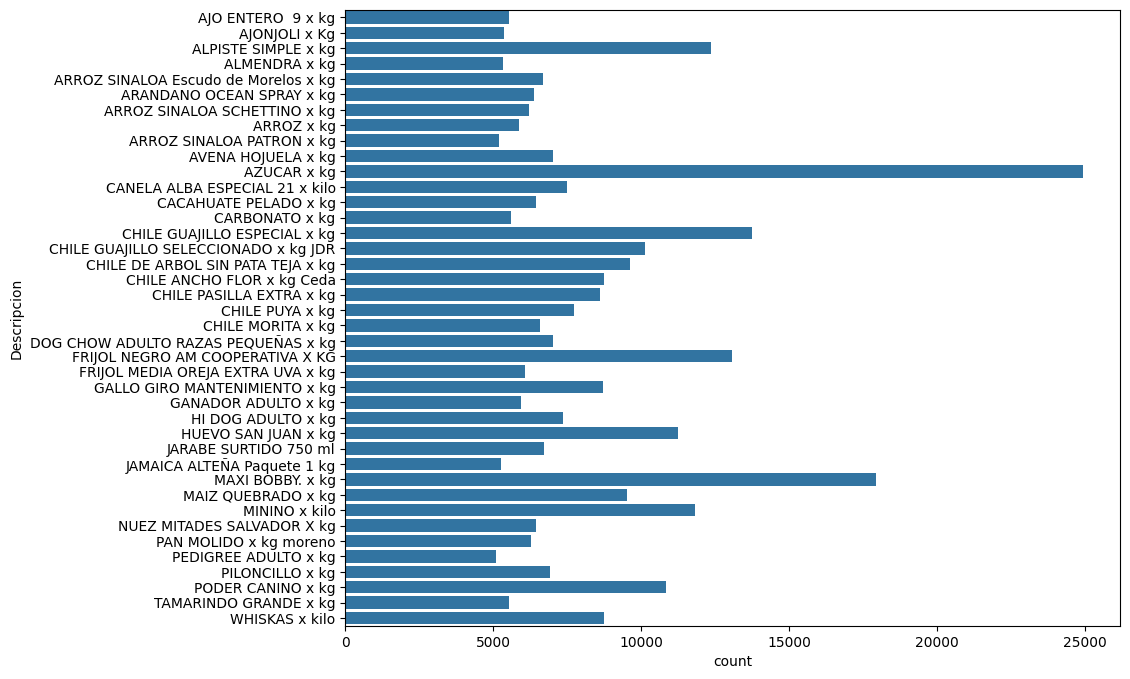

In [ ]:
#Productos más comprados
count_prod = df['Descripcion'].value_counts()
prod_counts = count_prod[count_prod> 5000]
prod_count_sorted = prod_counts.index
prod_count_sorted = sorted(prod_count_sorted, key=lambda x: x[:2])
filt_data = df[df['Descripcion'].isin(prod_count_sorted)]
print(count_prod)
#filt_data['FCNOMBRE'] = pd.Categorical(filt_data['FCIDPRODUCTO'], categories=prod_count_sorted, ordered=True)
plt.figure(figsize=(10, 8))
sns.countplot(y=filt_data['Descripcion'], order=prod_count_sorted)
plt.show()
#print(filt_data)

In [ ]:
# Obtenemos los nombres de las columnas del DataFrame compras_final y los almacenamos en colnames
colnames = df.columns
colnames

Index(['ProductoId', 'Descripcion', 'Cantidad', 'FechaEmision', 'Utilidad',
       'Ticket'],
      dtype='object')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Agrupar por producto y sumar 'FICANTIDAD' y 'VENTA_NETA' (o 'FCIMPTOTAL')
product_sales = df.groupby('Descripcion').agg({'Cantidad': 'sum', 'Utilidad': 'sum'}).reset_index()

# Ordenar los productos por la suma de 'FICANTIDAD' en orden descendente
product_sales = product_sales.sort_values(by='Cantidad', ascending=False)

# Visualizar los primeros 10 productos
print(product_sales.head(10))

                       Descripcion    Cantidad     Utilidad
121                    AZUCAR x kg  757881.554  1314.886291
599               MAXI BOBBY. x kg  507707.168   666.897115
823              PODER CANINO x kg  339184.795   755.542431
444  GALLO GIRO MANTENIMIENTO x kg  301138.713   631.391782
587             MAIZ QUEBRADO x kg  224667.306  1252.250718
506             HI DOG ADULTO x kg  161805.973   428.995388
528            HUEVO SAN JUAN x kg  150084.567   714.495684
630                  MININO x kilo  143905.239   621.601854
99    ARROZ SINALOA SCHETTINO x kg  140833.766   689.255286
98       ARROZ SINALOA PATRON x kg  117155.116   839.316862


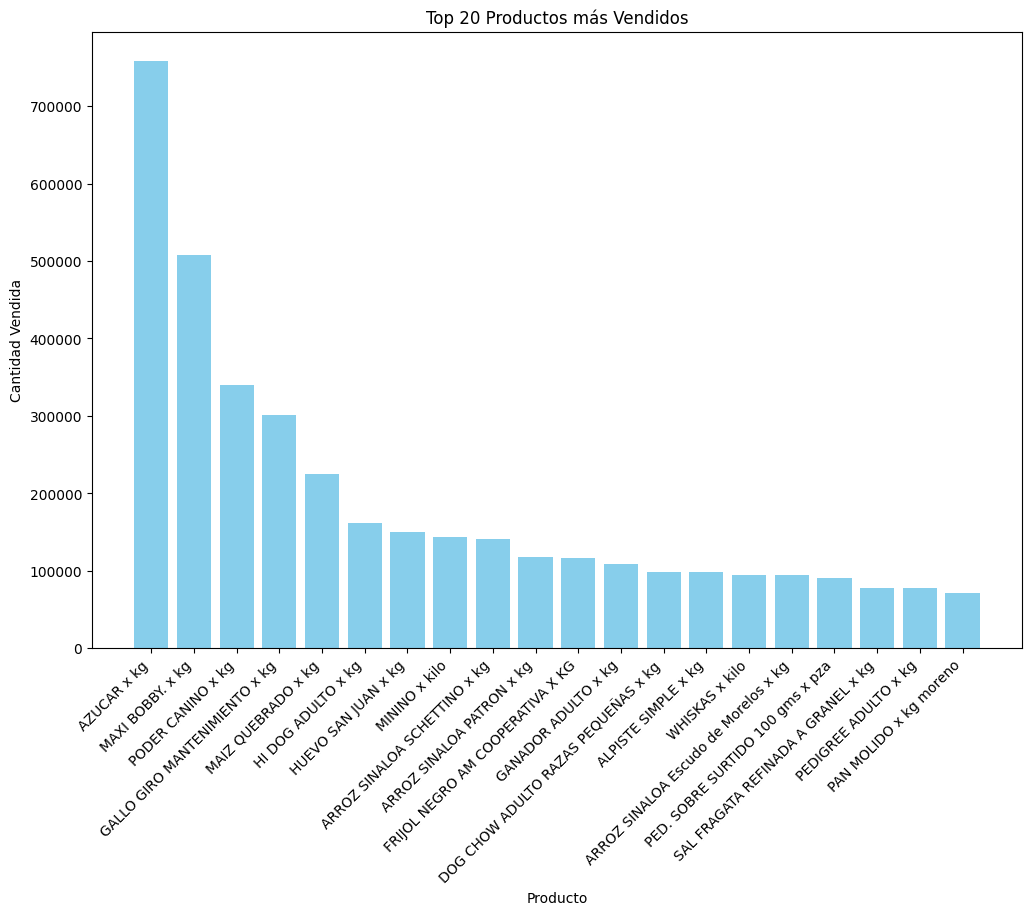

In [ ]:
# Seleccionar los primeros 10 productos más vendidos
top_n = 20
top_product_sales = product_sales.head(top_n)

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))
plt.bar(top_product_sales['Descripcion'], top_product_sales['Cantidad'], color='skyblue')
plt.xlabel('Producto')
plt.ylabel('Cantidad Vendida')
plt.title(f'Top {top_n} Productos más Vendidos')
plt.xticks(rotation=45, ha='right')  # Rotar y alinear las etiquetas del eje x para mejor visualización
plt.show()


## Association Rules Mining

### ECLAT algorithm

In [ ]:
!pip install pyECLAT

In [ ]:
# Agrupar los datos por FITICKET y transformar a listas
grouped = df.groupby('Ticket')['Descripcion'].apply(list)

# Crear un nuevo dataframe similar al dataset de mercado
transactions = pd.DataFrame(grouped.tolist())

print(transactions)

                                           0    \
0       FRIJOL FLOR DE MAYO B /10 kg ( Bueno )   
1                 MOLE DP Especial Pasta 10 kg   
2                                   PAL x kilo   
3           WHISKAS SOBRE SURTIDO 85 gms x pza   
4                                   DATIL X Kg   
...                                        ...   
247959                            TAPIOCA x kg   
247960          ALMENDRA CONFITADA PASTEL X kg   
247961                  PISTACHE CIMARRON 1 kg   
247962          NESCAFE CLASICO FRASCO 350 Gms   
247963       HIGIENICO PETALO 6/500 hoj. x pza   

                                   1                                 2    \
0         CHILE GUAJILLO ESPECIAL x kg                              None   
1               PAN MOLIDO x kg moreno               ALPISTE SIMPLE x kg   
2               DOG CHOW CACHORRO x kg              PEDIGREE ADULTO x kg   
3                                 None                              None   
4                  

In [ ]:
from pyECLAT import ECLAT
# Crear una instancia de ECLAT
eclat_instance = ECLAT(data=transactions, verbose=True)

100%|██████████| 1088/1088 [00:00<00:00, 1838.54it/s]


In [ ]:
indexes, support = eclat_instance.fit(min_support=0.08, min_combination=1, max_combination=3)

Combination 1 by 1


1it [00:02,  2.91s/it]


Combination 2 by 2


0it [00:00, ?it/s]


Combination 3 by 3


0it [00:00, ?it/s]


In [ ]:
support

{'AZUCAR x kg': 0.09765127195883273}

### Apriori algorithm

##### Reglas de asociación para la ciudad de México

In [ ]:
# Importamos las funciones apriori y association_rules del módulo mlxtend.frequent_patterns
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:
# Agrupamos el DataFrame df_domingo por 'FITICKET' y 'FCNOMBRE', sumando las cantidades ('FICANTIDAD')
df_grouped = df.groupby(['Ticket', 'Descripcion'])['Cantidad'].sum()
df_grouped.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Ticket     Descripcion                           
TB-105719  CHILE GUAJILLO ESPECIAL x kg               5.0
           FRIJOL FLOR DE MAYO B /10 kg ( Bueno )    10.0
TB-105720  ALPISTE SIMPLE x kg                       10.0
           ARROZ SINALOA PATRON x kg                 25.0
           CHILE GUAJILLO SELECCIONADO x kg JDR       2.0
Name: Cantidad, dtype: float64

In [ ]:
# Transformamos el DataFrame agrupado para que 'FCNOMBRE' se convierta en columnas y reiniciamos el índice
df_grouped = df_grouped.unstack().reset_index()
df_grouped.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Descripcion,Ticket,ABLANDADOR DE CARNES 1 KG,ACEITE 1 2 3. 1 lt x pza,ACEITE AVE 10 lt,ACEITE BAJIO 5 LT,ACEITE CRISTAL 1 LT X PZA,ACEITE CRISTAL 1.5 x pza,ACEITE CRISTAL 20 lt,ACEITE CRISTAL 5 lt x pieza,ACEITE DE AGUACATE .500 ML D artana,...,WINIS UNICORNIO MAXI TUBITO 16 PZAS,Yorkshire Terrier Adulto 4.54 kg,ZOTE BLANCO 400 Gms x pza,ZOTE ROSA 400 gms x pza,ZUCARITAS 1.2 Kg.,la costeña CHIPOTLES Adobados 220 Gms x pza,la costeña RAJAS 105 Gms x pza,la costeña RAJAS De Jalapeños .240 gms,no hay CHILE PASILLA EXTRA Briseño x kg M.N,no tocar CHILE GUAJILLO 2a VILLA x kg
0,TB-105719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TB-105720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TB-105721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TB-105722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TB-105723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_grouped.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Descripcion,Ticket,ABLANDADOR DE CARNES 1 KG,ACEITE 1 2 3. 1 lt x pza,ACEITE AVE 10 lt,ACEITE BAJIO 5 LT,ACEITE CRISTAL 1 LT X PZA,ACEITE CRISTAL 1.5 x pza,ACEITE CRISTAL 20 lt,ACEITE CRISTAL 5 lt x pieza,ACEITE DE AGUACATE .500 ML D artana,...,WINIS UNICORNIO MAXI TUBITO 16 PZAS,Yorkshire Terrier Adulto 4.54 kg,ZOTE BLANCO 400 Gms x pza,ZOTE ROSA 400 gms x pza,ZUCARITAS 1.2 Kg.,la costeña CHIPOTLES Adobados 220 Gms x pza,la costeña RAJAS 105 Gms x pza,la costeña RAJAS De Jalapeños .240 gms,no hay CHILE PASILLA EXTRA Briseño x kg M.N,no tocar CHILE GUAJILLO 2a VILLA x kg
247959,Tk-492771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247960,Tk-492774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247961,Tk-492780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247962,Tk-492781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247963,Tk-492782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Rellenamos los valores nulos con 0
df_grouped = df_grouped.fillna(0)
# Establecemos 'FITICKET' como el índice del DataFrame
df_grouped = df_grouped.set_index('Ticket')
df_grouped.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Descripcion,ABLANDADOR DE CARNES 1 KG,ACEITE 1 2 3. 1 lt x pza,ACEITE AVE 10 lt,ACEITE BAJIO 5 LT,ACEITE CRISTAL 1 LT X PZA,ACEITE CRISTAL 1.5 x pza,ACEITE CRISTAL 20 lt,ACEITE CRISTAL 5 lt x pieza,ACEITE DE AGUACATE .500 ML D artana,ACEITE DE AGUACATE 1 LT D artana,...,WINIS UNICORNIO MAXI TUBITO 16 PZAS,Yorkshire Terrier Adulto 4.54 kg,ZOTE BLANCO 400 Gms x pza,ZOTE ROSA 400 gms x pza,ZUCARITAS 1.2 Kg.,la costeña CHIPOTLES Adobados 220 Gms x pza,la costeña RAJAS 105 Gms x pza,la costeña RAJAS De Jalapeños .240 gms,no hay CHILE PASILLA EXTRA Briseño x kg M.N,no tocar CHILE GUAJILLO 2a VILLA x kg
Ticket,,,,,,,,,,,,,,,,,,,,,
TB-105719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TB-105720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TB-105721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TB-105722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TB-105723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Definimos una función para codificar los valores en True (si es mayor a 0) o False (si es menor o igual a 0)
def hot_encode(x):
    if(x<= 0):
        return False
    else:
        return True

# Aplicamos la función de codificación a todos los valores del DataFrame df_grouped
df_grouped = df_grouped.applymap(hot_encode)
df_grouped.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-33-ea891c99e028>:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_grouped = df_grouped.applymap(hot_encode)


Descripcion,ABLANDADOR DE CARNES 1 KG,ACEITE 1 2 3. 1 lt x pza,ACEITE AVE 10 lt,ACEITE BAJIO 5 LT,ACEITE CRISTAL 1 LT X PZA,ACEITE CRISTAL 1.5 x pza,ACEITE CRISTAL 20 lt,ACEITE CRISTAL 5 lt x pieza,ACEITE DE AGUACATE .500 ML D artana,ACEITE DE AGUACATE 1 LT D artana,...,WINIS UNICORNIO MAXI TUBITO 16 PZAS,Yorkshire Terrier Adulto 4.54 kg,ZOTE BLANCO 400 Gms x pza,ZOTE ROSA 400 gms x pza,ZUCARITAS 1.2 Kg.,la costeña CHIPOTLES Adobados 220 Gms x pza,la costeña RAJAS 105 Gms x pza,la costeña RAJAS De Jalapeños .240 gms,no hay CHILE PASILLA EXTRA Briseño x kg M.N,no tocar CHILE GUAJILLO 2a VILLA x kg
Ticket,,,,,,,,,,,,,,,,,,,,,
TB-105719,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
TB-105720,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
TB-105721,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
TB-105722,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
TB-105723,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Utilizamos el algoritmo apriori para encontrar conjuntos de elementos
# frecuentes en el DataFrame codificado con un soporte mínimo de 0.002
frq_items = apriori(df_grouped, min_support= 0.0065, use_colnames=True)

# Ordenamos los ítems frecuentes por el soporte de manera descendente
frq_items.sort_values(['support'], ascending=[False])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
14,0.097651,(AZUCAR x kg)
81,0.071309,(MAXI BOBBY. x kg)
26,0.054339,(CHILE GUAJILLO ESPECIAL x kg)
43,0.051979,(FRIJOL NEGRO AM COOPERATIVA X KG)
4,0.049056,(ALPISTE SIMPLE x kg)
...,...,...
0,0.006763,(ACEITE CRISTAL 1.5 x pza)
18,0.006674,(CANELA MOLIDA Molucas paq 1 kg)
85,0.006646,(MOLE DP Especial Pasta 5 kg)
91,0.006610,(OREGANO x kg)


In [ ]:
# Generamos las reglas de asociación a partir de los ítems frecuentes usando la métrica 'lift' y un umbral mínimo de 1
rules=association_rules(frq_items, metric='lift', min_threshold=0.1, num_itemsets=10000)

# Ordenamos las reglas de asociación por el valor de 'lift' de manera ascendente
rules.sort_values(['lift'], ascending=[True])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
10,(MAXI BOBBY. x kg),(AZUCAR x kg),0.071309,0.097651,0.009292,0.130302,1.334361,1.0,0.002328,1.037543,0.269818,0.058194,0.036184,0.112727
11,(AZUCAR x kg),(MAXI BOBBY. x kg),0.097651,0.071309,0.009292,0.095152,1.334361,1.0,0.002328,1.026350,0.277695,0.058194,0.025674,0.112727
1,(AZUCAR x kg),(ALPISTE SIMPLE x kg),0.097651,0.049056,0.007049,0.072190,1.471591,1.0,0.002259,1.024934,0.355144,0.050476,0.024328,0.107946
0,(ALPISTE SIMPLE x kg),(AZUCAR x kg),0.049056,0.097651,0.007049,0.143703,1.471591,1.0,0.002259,1.053780,0.336995,0.050476,0.051035,0.107946
4,(CHILE GUAJILLO ESPECIAL x kg),(AZUCAR x kg),0.054339,0.097651,0.008449,0.155485,1.592244,1.0,0.003143,1.068481,0.393328,0.058860,0.064092,0.121002
5,(AZUCAR x kg),(CHILE GUAJILLO ESPECIAL x kg),0.097651,0.054339,0.008449,0.086520,1.592244,1.0,0.003143,1.035230,0.412208,0.058860,0.034031,0.121002
7,(FRIJOL NEGRO AM COOPERATIVA X KG),(AZUCAR x kg),0.051979,0.097651,0.008981,0.172783,1.769388,1.0,0.003905,1.090825,0.458674,0.063855,0.083262,0.132377
6,(AZUCAR x kg),(FRIJOL NEGRO AM COOPERATIVA X KG),0.097651,0.051979,0.008981,0.091972,1.769388,1.0,0.003905,1.044043,0.481890,0.063855,0.042185,0.132377
8,(AZUCAR x kg),(HUEVO SAN JUAN x kg),0.097651,0.038469,0.009122,0.093417,2.428353,1.0,0.005366,1.060610,0.651853,0.071830,0.057146,0.165274
9,(HUEVO SAN JUAN x kg),(AZUCAR x kg),0.038469,0.097651,0.009122,0.237132,2.428353,1.0,0.005366,1.182837,0.611731,0.071830,0.154575,0.165274


In [ ]:
import plotly.express as px
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Poner aquí el scatterplot con confidence, support y lift
fig = px.scatter(rules, x="confidence", y="support", color='lift')
fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
frq_items['length']=frq_items['itemsets'].apply(lambda x:len(x))
print(frq_items.tail())

      support                                           itemsets  length
118  0.007985  (CHILE DE ARBOL SIN PATA TEJA x kg, CHILE GUAJ...       2
119  0.007392  (CHILE DE ARBOL SIN PATA TEJA x kg, CHILE MORI...       2
120  0.007477  (CHILE GUAJILLO ESPECIAL x kg, CHILE PASILLA E...       2
121  0.008687    (CHILE GUAJILLO ESPECIAL x kg, CHILE PUYA x kg)       2
122  0.009397                  (MAXI BOBBY. x kg, MININO x kilo)       2


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



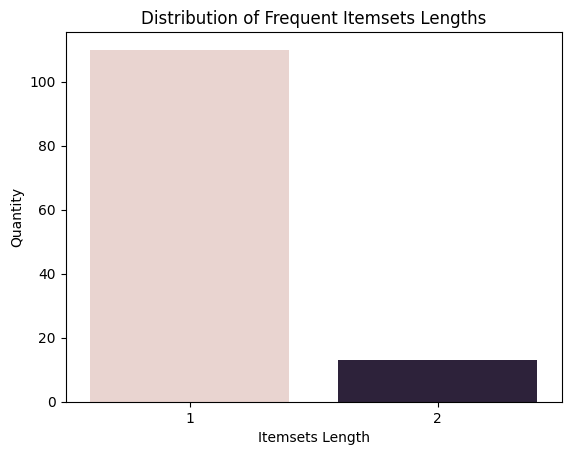

In [ ]:
# Crear el gráfico
sns.countplot(data=frq_items, x='length', hue='length')

# Personalizar el gráfico
plt.xlabel('Itemsets Length')
plt.ylabel('Quantity')
plt.title('Distribution of Frequent Itemsets Lengths')

# Quitar leyenda
plt.legend([],[], frameon=False)

#### Reglas de asociación con tickets asociados a cappuccino

### High Utility Itemset

In [ ]:
!pip install itemset-mining

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Importar bibliotecas para el algoritmo de alta utilidad de dos fases
from operator import attrgetter
from itemset_mining.two_phase_huim import TwoPhase

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Agrupar por FITICKET y FCNOMBRE y calcular el promedio
grouped = df.groupby(['Ticket', 'Descripcion']).agg(
    Cantidad=('Cantidad', lambda x: np.round(np.mean(x)).astype(int)),
    Utilidad=('Utilidad', lambda x: np.round(np.mean(x),2).astype(float))
).reset_index()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
grouped.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Ticket,Descripcion,Cantidad,Utilidad
0,TB-105719,CHILE GUAJILLO ESPECIAL x kg,5,0.13
1,TB-105719,FRIJOL FLOR DE MAYO B /10 kg ( Bueno ),10,0.19
2,TB-105720,ALPISTE SIMPLE x kg,10,0.10
3,TB-105720,ARROZ SINALOA PATRON x kg,25,0.10
4,TB-105720,CHILE GUAJILLO SELECCIONADO x kg JDR,2,0.25


In [ ]:
grouped.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(728790, 4)

In [ ]:
# Convertir a lista de transacciones
transactions = grouped.groupby('Ticket').apply(
    lambda x: [(row['Descripcion'], row['Cantidad']) for _, row in x.iterrows()]
).tolist()

# Crear diccionario de utilidades externas
external_utilities = grouped.drop_duplicates('Descripcion').set_index('Descripcion')['Utilidad'].to_dict()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-46-97551b91f111>:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [ ]:
# Aplicar el algoritmo TwoPhase
minutil = 5000.00
hui = TwoPhase(transactions, external_utilities, minutil)
result = hui.get_hui()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Ordenar y mostrar los resultados
sorted_result = sorted(result, key=attrgetter('itemset_utility'), reverse=True)
for record in sorted_result:
    print(f"Itemset: {record.items}, Utility: {record.itemset_utility}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[HUIRecord(items=('GALLO GIRO MANTENIMIENTO x kg',), itemset_utility=44943.44999999891),
 HUIRecord(items=('MAIZ QUEBRADO x kg',), itemset_utility=26742.84000000185),
 HUIRecord(items=('ARROZ SINALOA SCHETTINO x kg',), itemset_utility=22383.199999999233),
 HUIRecord(items=('POLLO NUTRIDOR x kg',), itemset_utility=15416.719999999901),
 HUIRecord(items=('FRIJOL NEGRO AM COOPERATIVA X KG',), itemset_utility=13867.32000000175),
 HUIRecord(items=('ARROZ SINALOA PATRON x kg',), itemset_utility=11642.200000000126),
 HUIRecord(items=('PILONCILLO x kg',), itemset_utility=11383.23999999987),
 HUIRecord(items=('GALLO GIRO MANTENIMIENTO x kg', 'MAIZ QUEBRADO x kg'), itemset_utility=10618.380000000056),
 HUIRecord(items=('PODER CANINO x kg',), itemset_utility=10108.499999999938),
 HUIRecord(items=('PAN MOLIDO x kg moreno',), itemset_utility=9915.500000000065),
 HUIRecord(items=('ALPISTE SIMPLE x kg',), itemset_utility=9753.200000000343),
 HUIRecord(items=('SAL FRAGATA REFINADA A GRANEL x kg',), ite